# WP5 Dataset Overview — Stats & Visualization

This notebook summarizes basic dataset statistics and provides simple visualizations of images and ground-truth labels for WP5-like 3D NIfTI volumes. It follows MONAI idioms (RAS orientation, dict transforms) and WP5 label policy (classes 0..4 for metrics; label 6 is present in labels and visualized but typically ignored for training/metrics).


## Setup & Config


In [51]:
import os, json, math, random, time, pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import nibabel as nib

import torch
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Orientationd, ScaleIntensityRanged
from monai.utils import set_determinism

print('Python:', os.sys.version)
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)
import monai, matplotlib
print('MONAI:', monai.__version__)
print('Matplotlib:', matplotlib.__version__)
print('Torch:', torch.__version__)

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); set_determinism(SEED)

# Paths (adjust if needed)
DATA_TRAIN = 'datalist_train.json'
DATA_TEST = 'datalist_test.json'
RUN_DIR = Path('runs') / 'data_overview'
RUN_DIR.mkdir(parents=True, exist_ok=True)

# Analysis options
MAX_CASES = None  # set to an int to subsample for speed
USE_MONAI_ORIENTATION = True  # load and orient to RAS using MONAI transforms
INT_CLIP = (-3.0, 8.5)  # robust WP5 scaling proxy for display & robust stats
CLASS_VALUES = [0,1,2,3,4,6]  # known label values; 6 is typically ignored in metrics
MIN_BINS = 128  # histogram bins for intensity plots

sns.set_context('talk'); sns.set_style('whitegrid')


Python: 3.9.5 (default, Nov 23 2021, 15:27:38) 
[GCC 9.3.0]
NumPy: 2.0.2
Pandas: 2.3.3
MONAI: 1.5.1+16.g14d7209d.dirty
Matplotlib: 3.9.4
Torch: 2.8.0+cu128


In [52]:
# !pip install seaborn

## Load Datalists


In [53]:
train_list = json.loads(Path(DATA_TRAIN).read_text()) if Path(DATA_TRAIN).exists() else []
test_list = json.loads(Path(DATA_TEST).read_text()) if Path(DATA_TEST).exists() else []

for r in train_list: r['split'] = 'train'
for r in test_list: r['split'] = 'test'
records = train_list + test_list
if MAX_CASES is not None:
    records = records[:MAX_CASES]

print(f'Train cases: {len(train_list)} | Test cases: {len(test_list)} | Total: {len(records)}')
# Peek
records[:2]


Train cases: 380 | Test cases: 180 | Total: 560


[{'image': '/data3/wp5/wp5-code/dataloaders/wp5-dataset/data/SN22B6_I55_2.5D_C1_1B250423_image.nii',
  'label': '/data3/wp5/wp5-code/dataloaders/wp5-dataset/data/SN22B6_I55_2.5D_C1_1B250423_label.nii',
  'id': 'SN22B6_I55_2.5D_C1_1B250423',
  'split': 'train'},
 {'image': '/data3/wp5/wp5-code/dataloaders/wp5-dataset/data/SN66B3_I82_3D_B1_3B250613_image.nii',
  'label': '/data3/wp5/wp5-code/dataloaders/wp5-dataset/data/SN66B3_I82_3D_B1_3B250613_label.nii',
  'id': 'SN66B3_I82_3D_B1_3B250613',
  'split': 'train'}]

## Helper Functions (I/O, Stats, Plots)


In [54]:
def _ensure_3d(arr):
    arr = np.asarray(arr)
    if arr.ndim == 4 and arr.shape[0] == 1:  # (C,X,Y,Z)
        return arr[0]
    if arr.ndim == 3:
        return arr
    raise ValueError(f'Unexpected array shape: {arr.shape}')

def load_case_oriented(image_path, label_path, use_monai=True):
    if use_monai:
        t = Compose([
            LoadImaged(keys=['image','label']),
            EnsureChannelFirstd(keys=['image','label']),
            Orientationd(keys=['image','label'], axcodes='RAS'),
        ])
        d = t({'image': image_path, 'label': label_path})
        img = d['image']
        if img.ndim == 4 and img.shape[0] == 1:
            img = img[0]
        lbl = d['label']
        if lbl.ndim == 4 and lbl.shape[0] == 1:
            lbl = lbl[0]
        lbl = np.asarray(lbl).astype(np.int32)
        meta = d.get('image_meta_dict', {})
        spacing = tuple(meta.get('spacing', (np.nan, np.nan, np.nan)))
        if any([s is None or (isinstance(s, float) and (math.isnan(s))) for s in spacing]):
            try:
                import nibabel as nib
                spacing = nib.load(str(image_path)).header.get_zooms()[:3]
            except Exception:
                spacing = (np.nan, np.nan, np.nan)
        return np.asarray(img), np.asarray(lbl), spacing
    else:
        import nibabel as nib
        img_nii = nib.load(str(image_path))
        lbl_nii = nib.load(str(label_path))
        img = np.asarray(img_nii.get_fdata(), dtype=np.float32)
        lbl = np.asarray(lbl_nii.get_fdata(), dtype=np.int32)
        spacing = img_nii.header.get_zooms()[:3]
        if img.ndim == 4 and img.shape[0] == 1: img = img[0]
        if lbl.ndim == 4 and lbl.shape[0] == 1: lbl = lbl[0]
        return img, lbl, spacing

def case_stats(rec, use_monai=USE_MONAI_ORIENTATION, int_clip=INT_CLIP):
    img, lbl, spacing = load_case_oriented(rec['image'], rec['label'], use_monai=use_monai)
    img = np.asarray(img, dtype=np.float32)
    lbl = np.asarray(lbl, dtype=np.int32)
    sx, sy, sz = img.shape
    voxels = int(sx*sy*sz)
    # Intensity stats (raw)
    imin, imax = float(np.min(img)), float(np.max(img))
    p1, p50, p99 = [float(x) for x in np.percentile(img, [1,50,99])]
    imean, istd = float(np.mean(img)), float(np.std(img))
    # Robust stats (clipped)
    l,u = int_clip
    img_c = np.clip(img, l, u)
    r_mean, r_std = float(img_c.mean()), float(img_c.std())
    # Label counts up to max label 6
    max_label = 6
    counts = np.bincount(lbl.ravel(), minlength=max_label+1)
    # Build record
    rec_out = {
        'id': rec.get('id', Path(rec['image']).stem),
        'split': rec.get('split','unknown'),
        'image': rec['image'],
        'label': rec['label'],
        'shape_x': int(sx), 'shape_y': int(sy), 'shape_z': int(sz),
        'spacing_x': float(spacing[0]) if spacing and len(spacing)>0 else np.nan,
        'spacing_y': float(spacing[1]) if spacing and len(spacing)>1 else np.nan,
        'spacing_z': float(spacing[2]) if spacing and len(spacing)>2 else np.nan,
        'n_voxels': voxels,
        'int_min': imin, 'int_p1': p1, 'int_p50': p50, 'int_p99': p99, 'int_max': imax,
        'int_mean': imean, 'int_std': istd,
        'robust_mean': r_mean, 'robust_std': r_std,
    }
    for k in range(max_label+1):
        rec_out[f'count_class_{k}'] = int(counts[k])
        rec_out[f'has_class_{k}'] = bool(counts[k] > 0)
    return rec_out

def plot_overlay_slices(img3d, lbl3d, title=None, clip=INT_CLIP, class_values=CLASS_VALUES):
    img = np.asarray(img3d, dtype=np.float32)
    lbl = np.asarray(lbl3d, dtype=np.int32)
    img = np.clip(img, clip[0], clip[1])
    img -= img.min()
    if img.max() > 0: img /= img.max()
    cx, cy, cz = img.shape[0]//2, img.shape[1]//2, img.shape[2]//2
    slices = [
        (img[:, :, cz], lbl[:, :, cz], f'Axial z={cz}'),
        (img[:, cy, :], lbl[:, cy, :], f'Coronal y={cy}'),
        (img[cx, :, :], lbl[cx, :, :], f'Sagittal x={cx}'),
    ]
    from matplotlib.colors import ListedColormap, BoundaryNorm
    colors = np.array([
        [0.0, 0.0, 0.0, 0.0],
        [0.90, 0.10, 0.10, 0.5],
        [0.10, 0.75, 0.10, 0.5],
        [0.10, 0.30, 0.90, 0.5],
        [0.95, 0.85, 0.10, 0.5],
        [0.60, 0.60, 0.60, 0.5],
        [0.10, 0.85, 0.85, 0.5],
        [1.00, 0.00, 1.00, 0.5],
    ])
    cmap = ListedColormap(colors)
    bounds = list(range(colors.shape[0]+1))
    norm = BoundaryNorm(bounds, cmap.N)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    for ax, (si, sl, subt) in zip(axes, slices):
        ax.imshow(si.T, cmap='gray', origin='lower')
        ax.imshow(sl.T, cmap=cmap, norm=norm, origin='lower')
        ax.set_title(subt)
        ax.axis('off')
    if title: fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def load_for_visual(rec, use_monai=USE_MONAI_ORIENTATION):
    img, lbl, _ = load_case_oriented(rec['image'], rec['label'], use_monai=use_monai)
    return img, lbl

def summarize_class_counts(df):
    cols = [c for c in df.columns if c.startswith('count_class_')]
    by_split = df.groupby('split')[cols].sum().T
    by_split['total'] = by_split.sum(axis=1)
    by_split.index = [int(i.split('_')[-1]) for i in by_split.index]
    by_split = by_split.sort_index()
    return by_split


## Compute Per-Case Stats


In [55]:
case_rows = []
for rec in tqdm(records, desc='Scanning cases'):
    try:
        row = case_stats(rec)
        case_rows.append(row)
    except Exception as e:
        print('Failed on', rec.get('id', rec.get('image')), e)

df = pd.DataFrame(case_rows)
print('Computed stats for', len(df), 'cases')
display(df.head(3))

# Save per-case summary
df.to_csv(RUN_DIR / 'summary_cases.csv', index=False)


Scanning cases: 100%|██████████| 560/560 [00:11<00:00, 47.72it/s]

Computed stats for 560 cases


,id,split,image,label,shape_x,shape_y,shape_z,spacing_x,spacing_y,spacing_z,...,count_class_2,has_class_2,count_class_3,has_class_3,count_class_4,has_class_4,count_class_5,has_class_5,count_class_6,has_class_6
0,SN22B6_I55_2.5D_C1_1B250423,train,/data3/wp5/wp5-code/dataloaders/wp5-dataset/da...,/data3/wp5/wp5-code/dataloaders/wp5-dataset/da...,76,77,62,1.0,1.0,1.0,...,34588,True,209,True,9891,True,0,False,0,False
1,SN66B3_I82_3D_B1_3B250613,train,/data3/wp5/wp5-code/dataloaders/wp5-dataset/da...,/data3/wp5/wp5-code/dataloaders/wp5-dataset/da...,119,114,106,1.0,1.0,1.0,...,152885,True,45030,True,34688,True,0,False,0,False
2,SN62B6_I59_3D_B1_3B250606,train,/data3/wp5/wp5-code/dataloaders/wp5-dataset/da...,/data3/wp5/wp5-code/dataloaders/wp5-dataset/da...,121,108,103,1.0,1.0,1.0,...,135897,True,9393,True,37088,True,0,False,0,False


## Aggregate Summaries


In [56]:
agg = {}
agg['n_cases_total'] = len(df)
agg['n_cases_train'] = int((df['split']=='train').sum())
agg['n_cases_test'] = int((df['split']=='test').sum())
agg['voxels_total'] = int(df['n_voxels'].sum())
for k in ['shape_x','shape_y','shape_z']:
    agg[f'{k}_min'] = int(df[k].min())
    agg[f'{k}_median'] = float(df[k].median())
    agg[f'{k}_max'] = int(df[k].max())
for k in ['spacing_x','spacing_y','spacing_z']:
    agg[f'{k}_min'] = float(df[k].min())
    agg[f'{k}_median'] = float(df[k].median())
    agg[f'{k}_max'] = float(df[k].max())
for k in ['robust_mean','robust_std','int_min','int_p1','int_p50','int_p99','int_max']:
    agg[f'{k}_median'] = float(df[k].median())
    agg[f'{k}_mean'] = float(df[k].mean())
class_totals = summarize_class_counts(df)
display(class_totals)
agg_df = pd.DataFrame([agg])
display(agg_df.T)
agg_df.to_csv(RUN_DIR / 'summary_aggregate.csv', index=False)
class_totals.to_csv(RUN_DIR / 'class_totals_by_split.csv')


split,test,train,total
0,98021786,196728074,294749860
1,14787325,29233609,44020934
2,14910289,28851884,43762173
3,506278,1110546,1616824
4,4998910,10059127,15058037
5,0,0,0
6,40374,297251,337625


,0
n_cases_total,5.600000e+02
n_cases_train,3.800000e+02
n_cases_test,1.800000e+02
voxels_total,3.995455e+08
shape_x_min,2.000000e+01
shape_x_median,7.500000e+01
shape_x_max,1.370000e+02
shape_y_min,4.500000e+01
shape_y_median,8.550000e+01
shape_y_max,1.910000e+02


## Class Distribution


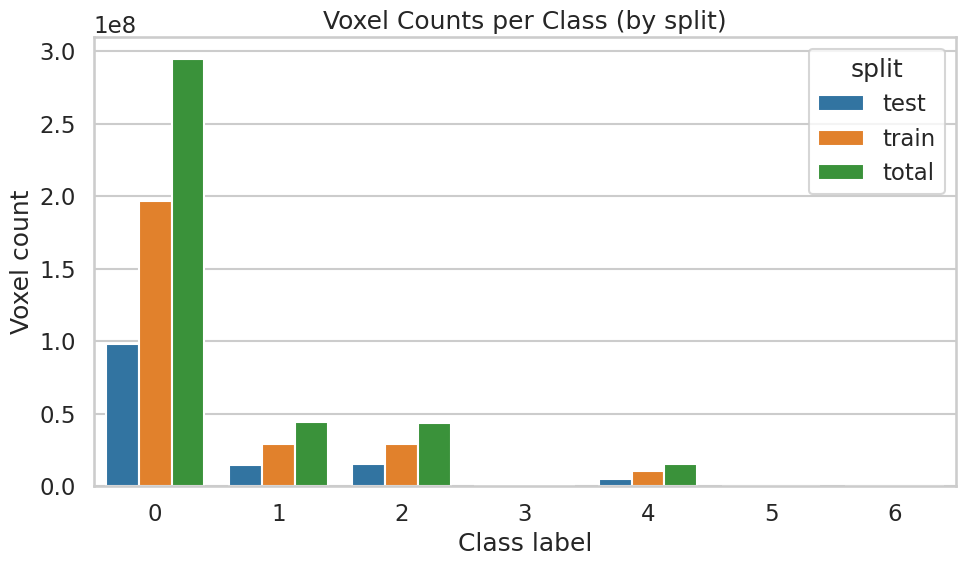

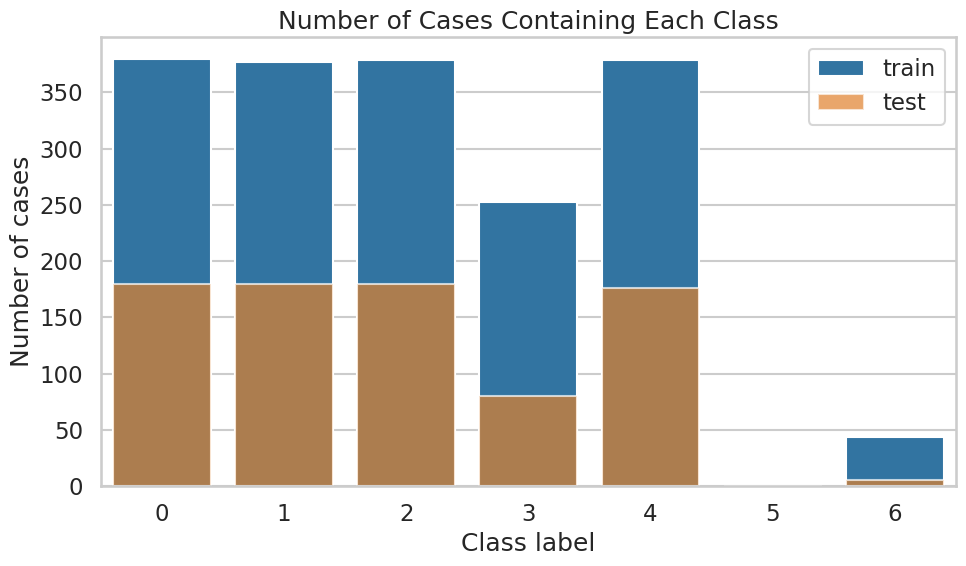

In [57]:
cls_df = summarize_class_counts(df).reset_index().rename(columns={'index':'class'})
melted = cls_df.melt(id_vars=['class'], var_name='split', value_name='voxels')
plt.figure(figsize=(10,6))
sns.barplot(data=melted, x='class', y='voxels', hue='split')
plt.title('Voxel Counts per Class (by split)')
plt.xlabel('Class label')
plt.ylabel('Voxel count')
plt.tight_layout()
plt.show()

presence_cols = [c for c in df.columns if c.startswith('has_class_')]
pres = df.groupby('split')[presence_cols].sum().T
pres.index = [int(i.split('_')[-1]) for i in pres.index]
pres = pres.sort_index()
plt.figure(figsize=(10,6))
sns.barplot(x=pres.index, y=pres['train'] if 'train' in pres.columns else pres.iloc[:,0], color='C0', label='train')
if 'test' in pres.columns:
    sns.barplot(x=pres.index, y=pres['test'], color='C1', alpha=0.7, label='test')
plt.title('Number of Cases Containing Each Class')
plt.xlabel('Class label')
plt.ylabel('Number of cases')
plt.legend()
plt.tight_layout()
plt.show()


## Shape and Spacing Distributions


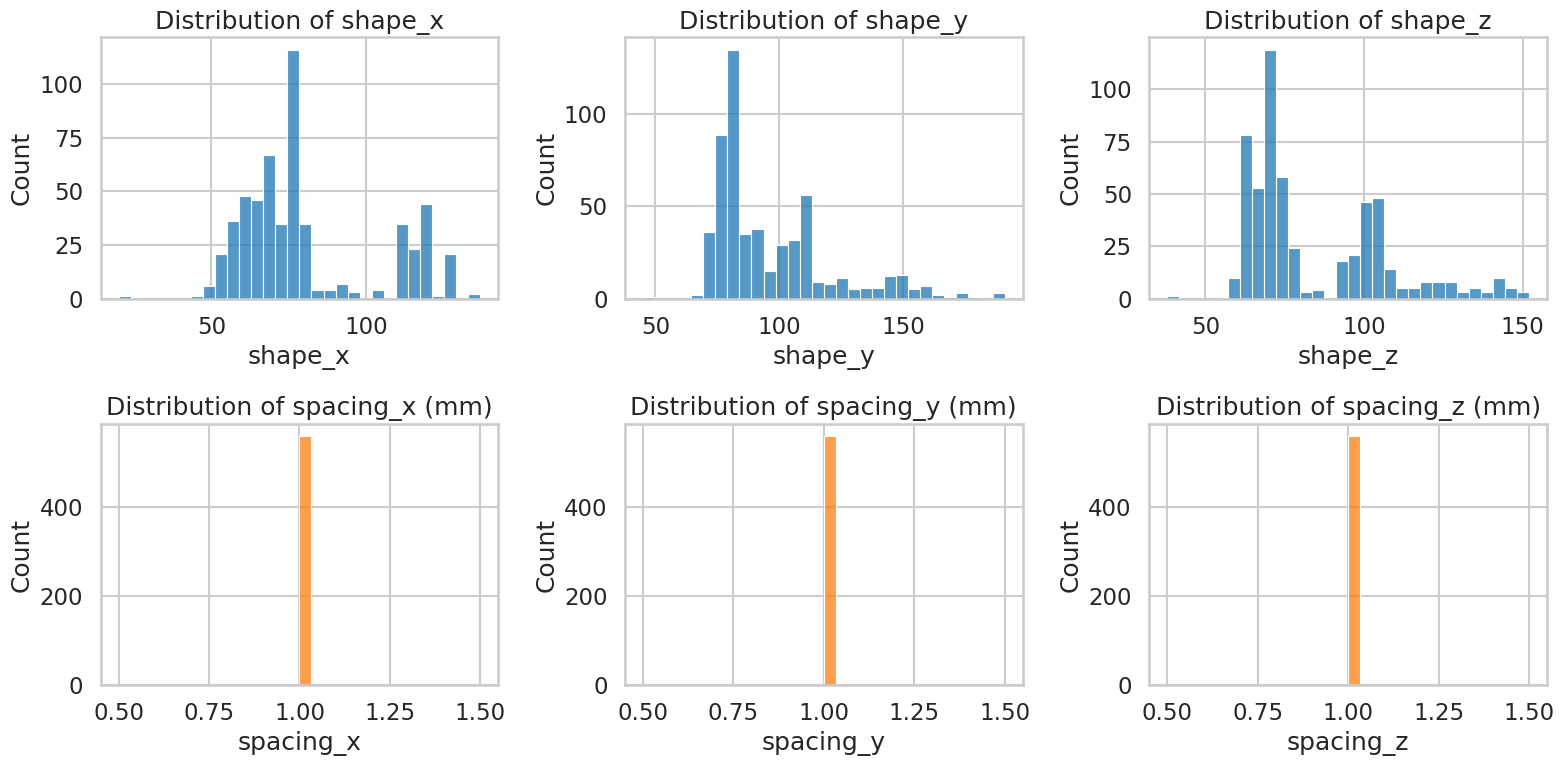

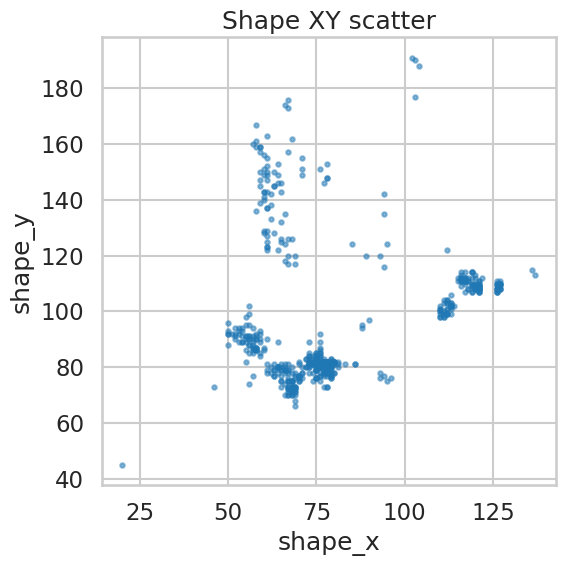

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()
for i, k in enumerate(['shape_x','shape_y','shape_z']):
    sns.histplot(df[k], bins=30, ax=axes[i], color='C0')
    axes[i].set_title(f'Distribution of {k}')
for i, k in enumerate(['spacing_x','spacing_y','spacing_z']):
    sns.histplot(df[k], bins=30, ax=axes[i+3], color='C1')
    axes[i+3].set_title(f'Distribution of {k} (mm)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df['shape_x'], df['shape_y'], s=10, alpha=0.5)
plt.xlabel('shape_x'); plt.ylabel('shape_y'); plt.title('Shape XY scatter')
plt.tight_layout(); plt.show()


## Intensity Histograms (sampled)


/home/peisheng/MONAI/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


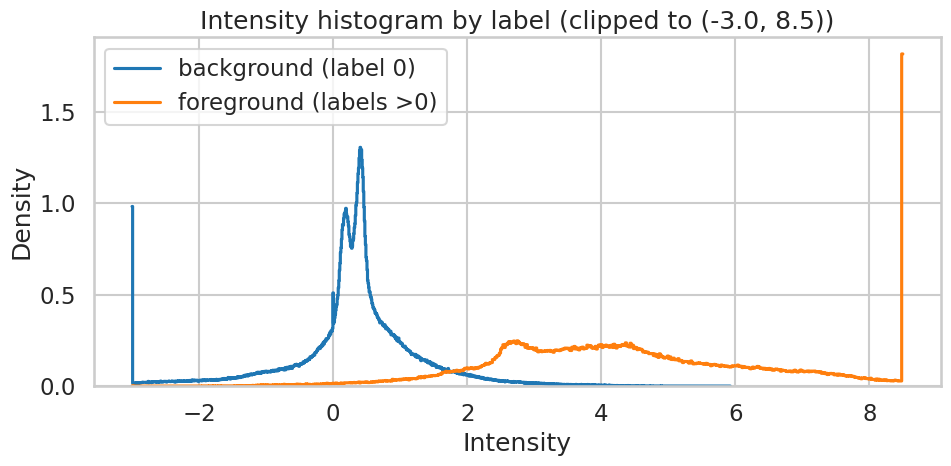

In [59]:
# Histogram split: background (label 0) vs foreground (labels >0)
sample_idxs = sample_indices if 'sample_indices' in globals() else (np.linspace(0, len(records)-1, min(20, len(records)), dtype=int) if len(records) else [])
bg_vals, fg_vals = [], []
for idx in sample_idxs:
    rec = records[idx]
    img, lbl = load_for_visual(rec)
    img = np.clip(img, INT_CLIP[0], INT_CLIP[1])
    bg_vals.append(img[lbl == 0])
    fg_vals.append(img[(lbl > 0)])
bg_vals = np.concatenate([v.ravel()[::8] for v in bg_vals]) if bg_vals else np.array([])
fg_vals = np.concatenate([v.ravel()[::8] for v in fg_vals]) if fg_vals else np.array([])

plt.figure(figsize=(10,5))
if bg_vals.size:
    sns.histplot(bg_vals, bins=max(MIN_BINS, int(np.sqrt(bg_vals.size))), color='tab:blue', label='background (label 0)', stat='density', element='step', fill=False)
if fg_vals.size:
    sns.histplot(fg_vals, bins=max(MIN_BINS, int(np.sqrt(fg_vals.size))), color='tab:orange', label='foreground (labels >0)', stat='density', element='step', fill=False)
plt.title(f'Intensity histogram by label (clipped to {INT_CLIP})')
plt.xlabel('Intensity'); plt.ylabel('Density'); plt.legend(); plt.tight_layout(); plt.show()


## Example Image/Label Overlays


In [60]:
colors = np.array([
    [0.0, 0.0, 0.0, 0.0],      # Class 0: Transparent (background)
    [0.90, 0.10, 0.10, 0.5],   # Class 1: Red
    [0.10, 0.75, 0.10, 0.5],   # Class 2: Green
    [0.10, 0.30, 0.90, 0.5],   # Class 3: Blue
    [0.95, 0.85, 0.10, 0.5],   # Class 4: Yellow
    [0.60, 0.60, 0.60, 0.5],   # Class 5: Gray (not used in WP5)
    [0.10, 0.85, 0.85, 0.5],   # Class 6: Cyan
    [1.00, 0.00, 1.00, 0.5],   # Class 7: Magenta (not used)
])


## Notes
- Orientations are standardized to RAS for both image and label before visualization.
- Intensities are shown after robust clipping to the WP5 proxy range (-3, 8.5), then normalized to [0,1] for display.
- Class 6 appears in WP5 labels but is typically ignored for training/metrics; it is included in counts and overlays for completeness.
- CSV outputs are written to `runs/data_overview/`:
  - `summary_cases.csv`: per-case shapes, spacings, intensity stats, class counts/presence.
  - `summary_aggregate.csv`: overall medians and totals.
  - `class_totals_by_split.csv`: voxel totals per class by split.

For WP5 policies and transforms, see `WP5_Segmentation_Data_Guide.md`.


/home/peisheng/MONAI/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


Using training volume: /data3/wp5/wp5-code/dataloaders/wp5-dataset/data/SN22B6_I55_2.5D_C1_1B250423_image.nii
Volume shape: (76, 77, 62); selected 1/62 slices -> [0]


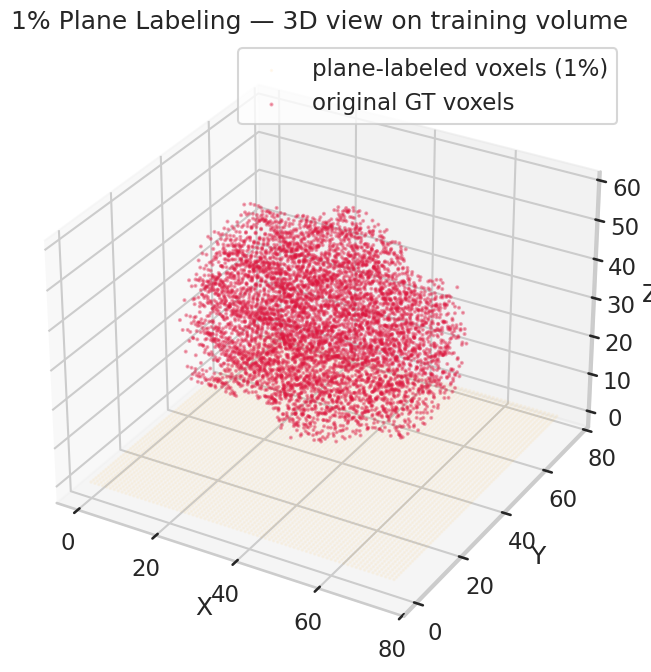

In [61]:
# 1% slicing demo (concept) — plane-labeling on a real training volume
# All voxels on each selected z-plane are considered labeled (conceptual illustration).
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# pick a real training volume when available
rec_demo = None
if 'train_list' in globals() and isinstance(train_list, list) and len(train_list):
    rec_demo = train_list[0]
else:
    # fallback to any case with foreground
    cand_demo = None
    if not df.empty:
        for _, row in df.iterrows():
            if int(row.get('has_class_1', 0)) or int(row.get('has_class_2', 0)) or int(row.get('has_class_3', 0)) or int(row.get('has_class_4', 0)):
                cand_demo = row
                break
        if cand_demo is None:
            cand_demo = df.iloc[0]
        rec_demo = {'image': cand_demo['image'], 'label': cand_demo['label']}

if rec_demo is not None:
    # load the real training volume
    if isinstance(rec_demo, dict) and 'image' in rec_demo:
        rec = rec_demo
    else:
        rec = {'image': rec_demo['image'], 'label': rec_demo['label']}
    img3d, lbl3d = load_for_visual(rec)
    X, Y, Z = img3d.shape
    n_sel = max(1, int(round(Z * 0.01)))
    sel_slices = np.linspace(0, Z - 1, n_sel, dtype=int)

    # plane labeling: every voxel on the selected planes is labeled
    plane_mask = np.zeros_like(lbl3d, dtype=bool)
    plane_mask[:, :, sel_slices] = True

    # sample coordinates for 3D scatter (to keep it light)
    def sample_coords(coords, max_points=10000):
        if coords.shape[0] > max_points:
            idx = np.linspace(0, coords.shape[0]-1, max_points, dtype=int)
            coords = coords[idx]
        return coords

    coords_plane = np.argwhere(plane_mask)
    coords_gt = np.argwhere(lbl3d > 0)
    coords_plane = sample_coords(coords_plane, 8000)
    coords_gt = sample_coords(coords_gt, 6000)

    print(f"Using training volume: {rec.get('image','NA')}")
    print(f"Volume shape: {img3d.shape}; selected {len(sel_slices)}/{Z} slices -> {sel_slices.tolist()[:8]}{'...' if len(sel_slices)>8 else ''}")

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')
    if coords_plane.size:
        ax.scatter(coords_plane[:,0], coords_plane[:,1], coords_plane[:,2], s=1, alpha=0.06, color='orange', label='plane-labeled voxels (1%)')
    if coords_gt.size:
        ax.scatter(coords_gt[:,0], coords_gt[:,1], coords_gt[:,2], s=2, alpha=0.35, color='crimson', label='original GT voxels')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title('1% Plane Labeling — 3D view on training volume')
    ax.legend(loc='upper right')
    plt.tight_layout(); plt.show()
else:
    print('No training cases available for 1% slicing demo.')


Plotting 5 axial slices with class 3 present: [21, 22, 23, 24, 25]


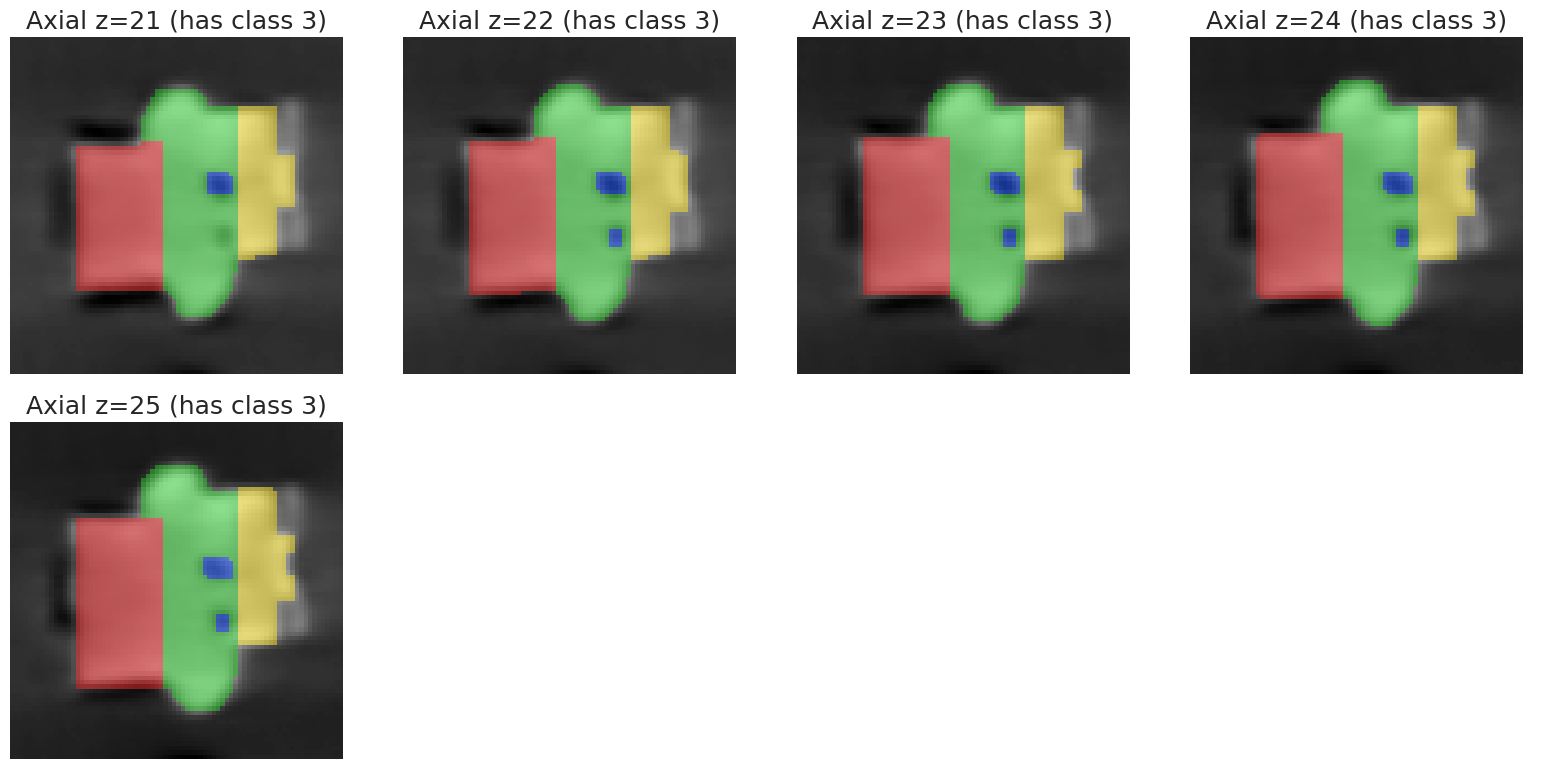

In [62]:
# Simple 2D visualization: axial slices that all contain class 3
# Select a real training volume, find z-planes with class 3 present, and plot overlays.
from matplotlib.colors import ListedColormap, BoundaryNorm

# pick a training case with class 3
rec_vis = None
if 'train_list' in globals() and isinstance(train_list, list) and len(train_list):
    # try to find one with class 3
    found = None
    if not 'df' in globals() or df.empty:
        # fallback: just take the first train_list entry
        found = train_list[0]
    else:
        for _, row in df.iterrows():
            if row.get('split','train') == 'train' and int(row.get('has_class_3', 0)):
                found = {'image': row['image'], 'label': row['label']}
                break
        if found is None:
            found = train_list[0]
    rec_vis = found
elif not df.empty:
    # fallback from df
    row = None
    for _, r in df.iterrows():
        if int(r.get('has_class_3', 0)):
            row = r; break
    if row is None:
        row = df.iloc[0]
    rec_vis = {'image': row['image'], 'label': row['label']}

if rec_vis is not None:
    img3d, lbl3d = load_for_visual(rec_vis)
    # robust display scale
    img = np.clip(img3d.astype(np.float32), INT_CLIP[0], INT_CLIP[1])
    img -= img.min()
    if img.max() > 0: img /= img.max()

    Z = img.shape[2]
    has3 = np.where((lbl3d == 3).any(axis=(0,1)))[0]
    if has3.size == 0:
        print('Selected case has no class 3 slices; choose another case.')
    else:
        n_show = min(8, has3.size)
        # choose evenly spaced subset of slices that all contain class 3
        sel = np.linspace(0, has3.size - 1, n_show, dtype=int)
        zs = has3[sel]
        print(f'Plotting {len(zs)} axial slices with class 3 present:', zs.tolist())

        # colormap for labels (transparent for 0)
        colors = np.array([
            [0.0, 0.0, 0.0, 0.0],  # 0 background transparent
            [0.90, 0.10, 0.10, 0.5],  # 1 red
            [0.10, 0.75, 0.10, 0.5],  # 2 green
            [0.10, 0.30, 0.90, 0.6],  # 3 blue (slightly more opaque)
            [0.95, 0.85, 0.10, 0.5],  # 4 yellow
            [0.60, 0.60, 0.60, 0.4],  # 5 (unused) gray
            [0.10, 0.85, 0.85, 0.5],  # 6 cyan
            [1.00, 0.00, 1.00, 0.5],  # 7 fallback
        ])
        cmap = ListedColormap(colors)
        norm = BoundaryNorm(list(range(colors.shape[0]+1)), cmap.N)

        # plot grid
        cols = min(4, n_show)
        rows = int(np.ceil(n_show / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        axes = np.atleast_1d(axes).ravel()

        for ax, z in zip(axes, zs):
            si = img[:, :, z]
            sl = lbl3d[:, :, z]
            ax.imshow(si.T, cmap='gray', origin='lower')
            ax.imshow(sl.T, cmap=cmap, norm=norm, origin='lower')
            ax.set_title(f'Axial z={int(z)} (has class 3)')
            ax.axis('off')
        # hide any unused axes
        for ax in axes[len(zs):]:
            ax.axis('off')
        plt.tight_layout(); plt.show()
else:
    print('No case available for visualization.')


/home/peisheng/MONAI/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


Selected indices -> x: 47 (has3=True), y: 41 (has3=True), z: 23 (has3=True)
Volume: SN22B6_I55_2.5D_C1_1B250423 (split: train)


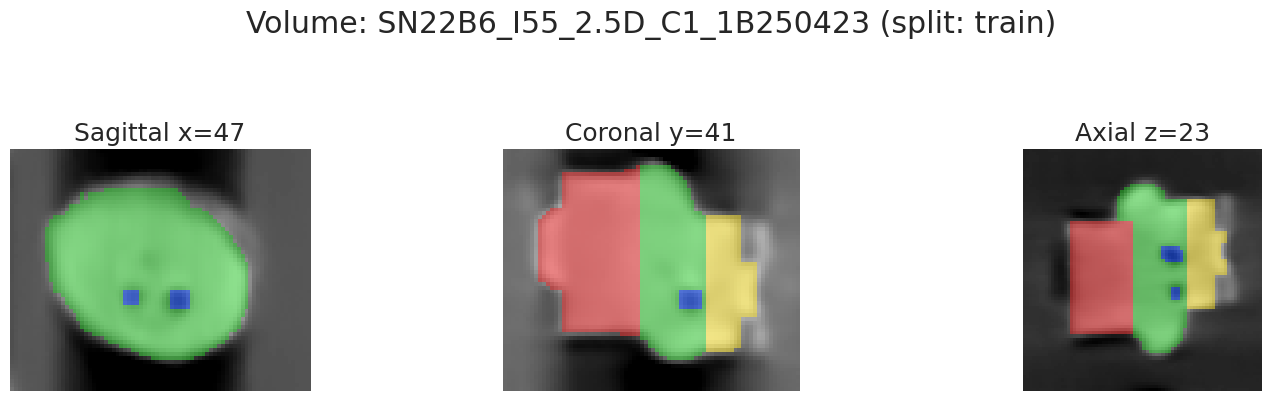

In [64]:
# One-slice per axis overlay (X/Y/Z) — prefer class 3, fallback to center
from matplotlib.colors import ListedColormap, BoundaryNorm

# choose a training case with class 3 if possible
rec_axis = None
if 'train_list' in globals() and isinstance(train_list, list) and len(train_list):
    chosen = None
    if 'df' in globals() and not df.empty:
        for _, row in df.iterrows():
            if row.get('split', 'train') == 'train' and int(row.get('has_class_3', 0)):
                chosen = {'image': row['image'], 'label': row['label']}
                break
    if chosen is None:
        chosen = train_list[0]
    rec_axis = chosen
elif 'df' in globals() and not df.empty:
    row = None
    for _, r in df.iterrows():
        if int(r.get('has_class_3', 0)):
            row = r; break
    if row is None:
        row = df.iloc[0]
    rec_axis = {'image': row['image'], 'label': row['label']}

if rec_axis is not None:
    img3d, lbl3d = load_for_visual(rec_axis)
    img = np.clip(img3d.astype(np.float32), INT_CLIP[0], INT_CLIP[1])
    img -= img.min()
    if img.max() > 0: img /= img.max()
    X, Y, Z = img.shape

    # find preferred planes with class 3; fallback to centers
    has3_x = (lbl3d == 3).any(axis=(1,2))
    has3_y = (lbl3d == 3).any(axis=(0,2))
    has3_z = (lbl3d == 3).any(axis=(0,1))

    x_idx = int(np.where(has3_x)[0][len(np.where(has3_x)[0])//2]) if has3_x.any() else X//2
    y_idx = int(np.where(has3_y)[0][len(np.where(has3_y)[0])//2]) if has3_y.any() else Y//2
    z_idx = int(np.where(has3_z)[0][len(np.where(has3_z)[0])//2]) if has3_z.any() else Z//2

    # volume name (prefer id if present, else derive from image path)
    vol_name = rec_axis.get('id', rec_axis['image'].split('/')[-1].replace('_image.nii', ''))
    split_name = rec_axis.get('split', 'train' if 'split' not in globals() else split)

    print(f'Selected indices -> x: {x_idx} (has3={bool(has3_x.any())}), y: {y_idx} (has3={bool(has3_y.any())}), z: {z_idx} (has3={bool(has3_z.any())})')
    print(f'Volume: {vol_name} (split: {split_name})')

    # colormap (transparent background 0; emphasize class 3)
    colors = np.array([
        [0.0, 0.0, 0.0, 0.0],  # 0 background
        [0.90, 0.10, 0.10, 0.5],  # 1 red
        [0.10, 0.75, 0.10, 0.5],  # 2 green
        [0.10, 0.30, 0.90, 0.65], # 3 blue emphasized
        [0.95, 0.85, 0.10, 0.5],  # 4 yellow
        [0.60, 0.60, 0.60, 0.4],  # 5 gray
        [0.10, 0.85, 0.85, 0.5],  # 6 cyan
        [1.00, 0.00, 1.00, 0.5],  # 7 fallback
    ])
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(list(range(colors.shape[0]+1)), cmap.N)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f'Volume: {vol_name} (split: {split_name})', y=1.02)

    # Sagittal (X plane)
    si = img[x_idx, :, :]
    sl = lbl3d[x_idx, :, :]
    axes[0].imshow(si.T, cmap='gray', origin='lower')
    axes[0].imshow(sl.T, cmap=cmap, norm=norm, origin='lower')
    axes[0].set_title(f'Sagittal x={x_idx}')
    axes[0].axis('off')

    # Coronal (Y plane)
    si = img[:, y_idx, :]
    sl = lbl3d[:, y_idx, :]
    axes[1].imshow(si.T, cmap='gray', origin='lower')
    axes[1].imshow(sl.T, cmap=cmap, norm=norm, origin='lower')
    axes[1].set_title(f'Coronal y={y_idx}')
    axes[1].axis('off')

    # Axial (Z plane)
    si = img[:, :, z_idx]
    sl = lbl3d[:, :, z_idx]
    axes[2].imshow(si.T, cmap='gray', origin='lower')
    axes[2].imshow(sl.T, cmap=cmap, norm=norm, origin='lower')
    axes[2].set_title(f'Axial z={z_idx}')
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()
else:
    print('No case available for axis-wise visualization.')
